In [1]:
import numpy as np
import opendssdirect as dss
from utils.device.Inverter import Inverter
from utils.controller.AdaptiveInvController import AdaptiveInvController
from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0
#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node
Delay_VBPCurveShift = np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Inappropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
dss.run_command('Redirect feeder/feeder34_B_NR/feeder34_B_NR.dss')

dss.Solution.Solve()
if not dss.Solution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


In [2]:
#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='../Data Files/testpvnum10/'
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time),4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
timeList = list(range(TotalTimeSteps))

Reading Data for Pecan Street is done.
Starting Interpolation...


Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.


/home/toanngo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


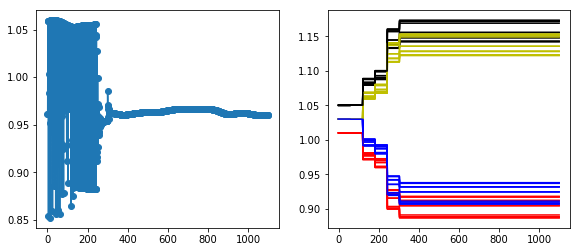

In [4]:
#Create noise vector
Noise = np.empty([TotalTimeSteps, TotalLoads])
for node in range(TotalLoads):
    Noise[:,node] = np.random.randn(TotalTimeSteps) 

#Add noise to loads
for node in range(TotalLoads):
    Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

if NoiseMultiplyer > 0:
    print('Load Interpolation has been done. Noise was added to the load profile.') 
else:
    print('Load Interpolation has been done. No Noise was added to the load profile.') 

MaxGenerationPossible = np.max(Generation, axis = 0)
sbar = MaxGenerationPossible


#########################################################
################### RESTART OPENDSS #####################
#########################################################
dss.run_command('Redirect feeder/feeder34_B_NR/feeder34_B_NR.dss')
dss.Solution.Solve()


if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

#set Source Info for OpenDSS
#setSourceInfo(dss,['source'],'pu',[SlackBusVoltage]) 
dss.Vsources.PU(SlackBusVoltage)
############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""
nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

for i in range(len(AllLoadNames)):
    df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
    nodes[i] = df
    nodes[i].loc['Generation'] = Generation[:,i]
    nodes[i].loc['P'] = 0
    nodes[i].loc['Q'] = 0

################################################
############ INIT INVERTERS ####################
################################################
""" 
 inverters' variable is a dictionary contains all the inverters in the grid,
 with KEY is the node's number where we have inverters, VALUE is a list of inverters at that node.
 
 Each inverter has a dictionary:
     'device': Inverter_Object
     'controller: Controller_Object
     'info': contain scenario information in a dataframe (solar generation, sbar) for each timestep at that node
 }
"""

inverters = {}
features = ['Generation', 'sbar']

# we create inverters from node 5 to node (5+13)
offset = 5
numberofInverters = 13

for i in range(len(AllLoadNames)):
    inverters[i] = []
    if offset-1 < i < numberofInverters + offset:
        # inverter device
        inv = {}
        inv['device'] = Inverter(timeList,lpf_meas=1,lpf_output=0.1)
        #controller: timeList, VBP is initial VBP, delayTimer is the delay control on VBP
        inv['controller'] = AdaptiveInvController(timeList, 
                                                  VBP = np.array([1.01, 1.03, 1.03, 1.05]), 
                                                  delayTimer=Delay_VBPCurveShift[i],
                                                  device=inv['device'])
        
        #prepare info
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        df.loc['Generation'] = Generation[:,i]
        df.loc['sbar'] = sbar[i]
        timeList = list(range(TotalTimeSteps))
        inv['info'] = df
        inverters[i].append(inv)


#for each timestep in the simulation
for timeStep in range(TotalTimeSteps):
    ####################################################
    ################ run the simulation ################
    ####################################################
    #for the first steps, we just initialize voltage value, no pq injection
    if timeStep == 0:
        for node in range(len(AllLoadNames)):
            nodeName = AllLoadNames[node]
            dss.Loads.Name(nodeName) 
            dss.Loads.kW(Load[timeStep, node])
            dss.Loads.kvar(pf_converted*Load[timeStep, node])
            #setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
            #setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
            
    #otherwise, we add Active Power (P) and Reactive Power (Q) which we injected at last timestep
    #to the grid at that node
    else:
        for node in range(len(AllLoadNames)):
            nodeName = AllLoadNames[node]
            dss.Loads.Name(nodeName) #set active element
            dss.Loads.kW(Load[timeStep, node] + nodes[node].at['P', timeStep-1])
            dss.Loads.kvar(pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1])
            #setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
            #setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

    #solve() openDSS with new values of Load
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', timeStep)

    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    for nodeName in AllLoadNames:
        dss.Loads.Name(nodeName)
        voltage = dss.CktElement.VoltagesMagAng()
        voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))
        nodeInfo.append(voltagePU)
    
    #distribute voltage to node
    for i in range(len(nodes)):
        node = nodes[i]
        node.at['Voltage', timeStep] = nodeInfo[i]
    
    #############################################################
    #############################################################
    #############################################################
    #at hack timestep, we do this
    if timeStep == TimeStepOfHack-1:
        #with each node...
        for node in range(len(AllLoadNames)):
            #if we have inverters at that node...
            if inverters[node] != []:
                #we get the first inverter in the list...
                inverter = inverters[node][0]
                
                #we create a new inverter, called hacked inverter, this controller is FixedInvController
                #that the Controller doesnt change the VBP w.r.t timestep
                hackedInv = copy.deepcopy(inverter)
                for k in range(timeStep, TotalTimeSteps):
                    hackedInv['controller'] = FixedInvController(timeList, 
                                                                 VBP = np.array([1.01, 1.015, 1.015, 1.02]),
                                                                 device=hackedInv)
                
                #change the sbar, generation of hacked Inverter Info, control percentHacked
                hackedInv['info'].loc['sbar'][timeStep:] = hackedInv['info'].loc['sbar'][timeStep:]*PercentHacked[node]
                hackedInv['info'].loc['Generation'][timeStep:] = hackedInv['info'].loc['Generation'][timeStep:]*PercentHacked[node]
                #add the hacked inverter into the list of inverters at that node
                inverters[node].append(hackedInv)
                #generation and sbar change on the original inverter, only control 1-percentHacked
                inverter['info'].loc['sbar'][timeStep:] = inverter['info'].loc['sbar'][timeStep:]*(1-PercentHacked[node])
                inverter['info'].loc['Generation'][timeStep:] = inverter['info'].loc['Generation'][timeStep:]*(1-PercentHacked[node])
    ########################################################################
    ########################################################################
    ########################################################################

    # with each node in the grid...
    for node in range(len(AllLoadNames)):
        #if we have inverters at that node then...
        if inverters[node] != []:
            invertersNode = inverters[node] #get the list of inverters at that node
            for inverter in invertersNode: #get an inverter at that node            
                #################################################
                device = inverter['device']
                controller = inverter['controller']
                info = inverter['info']

                #calcuate P Q injected into the grid by an inverter
                p_inv, q_inv = device.step(v=nodes[node].at['Voltage', timeStep], 
                                                solar_irr=info.at['Generation', timeStep],
                                                solar_minval=5, 
                                                Sbar=info.at['sbar', timeStep], 
                                                VBP= controller.get_VBP())

                #add P Q injected to the node
                nodes[node].at['P', timeStep] += p_inv
                nodes[node].at['Q', timeStep] += q_inv

                #change internal VBP 
                controller.act(nk=0.1, device=device, thresh=0.25)

######### drawing #####################
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(20)
f.add_subplot(1,4,1)
plt.plot(nodes[7].loc['Voltage'], marker='o')

for i in range(5,18):
    x = inverters[i][0]['controller'].VBP
    y=np.zeros([len(x),x[0].shape[0]])
    for i in range(len(x)):
        y[i,:] = x[i]
    f.add_subplot(1,4,2)
    plt.plot(y[:,0], 'r')
    plt.plot(y[:,1], 'y')
    plt.plot(y[:,2], 'b')
    plt.plot(y[:,3], 'k')
    
plt.show()